In [1]:
import pandas as pd
import numpy as np

# File paths
file_paths = {
    "2022-2023": "/content/gsw-shg-en 2022-2023.csv",
    "2023-2024": "/content/gsw-shg-en 2023-2024.csv",
    "2024-2025": "/content/gsw-shg-en 2024-2025.csv",
}

# Define the 4 outputs
targets = [
    ("Corn", "Bay & Lakes", "corn_bay_lakes.csv"),
    ("Soybeans", "Bay & Lakes", "soybeans_bay_lakes.csv"),
    ("Corn", "St. Lawrence", "corn_st_lawrence.csv"),
    ("Soybeans", "St. Lawrence", "soybeans_st_lawrence.csv"),
]

# Helper to assign grain week and crop year
def assign_grain_week_and_crop_year(date):
    if pd.isna(date):
        return pd.NA, pd.NA
    year = date.year
    aug_1 = pd.Timestamp(year=year, month=8, day=1)
    if date >= aug_1:
        crop_year = f"{year}-{year+1}"
        week = ((date - aug_1).days // 7) + 1
    else:
        crop_year = f"{year-1}-{year}"
        week = ((date - pd.Timestamp(year=year-1, month=8, day=1)).days // 7) + 1
    if 1 <= week <= 52:
        return f"GW{week}", crop_year
    else:
        return pd.NA, pd.NA

# Load and combine all datasets
all_data = []
for label, path in file_paths.items():
    df = pd.read_csv(path)
    df["week_ending_date"] = pd.to_datetime(df["week_ending_date"], errors='coerce')
    df["Ktonnes"] = pd.to_numeric(df["Ktonnes"], errors='coerce')
    df["region"].fillna("Unknown", inplace=True)
    df["worksheet"] = df["worksheet"].fillna("Unknown")

    # Assign grain_week and crop_year
    df[["grain_week", "crop_year"]] = df["week_ending_date"].apply(lambda d: pd.Series(assign_grain_week_and_crop_year(d)))

    # Keep only valid rows
    df = df[df["grain_week"].notna()]
    all_data.append(df)

# Combine all crop years into one DataFrame
df_all = pd.concat(all_data)

# Now generate 4 outputs
for grain, region, output_file in targets:
    print(f"🔄 Processing {output_file}...")

    # Filter by conditions
    filtered = df_all[
        (df_all["worksheet"] == "Terminal Exports") &
        (df_all["grain"] == grain) &
        (df_all["region"] == region)
    ]

    # Group by grain_week + crop_year (no mixing across years)
    grouped = (
        filtered.groupby(["crop_year", "grain_week"])["Ktonnes"]
        .sum()
        .reset_index()
        .sort_values(["crop_year", "grain_week"])
    )

    # Save to CSV
    output_path = f"/content/{output_file}"
    grouped.to_csv(output_path, index=False)
    print(f"✅ Saved: {output_path}")

<ipython-input-1-0a390525ae08>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["region"].fillna("Unknown", inplace=True)
<ipython-input-1-0a390525ae08>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

🔄 Processing corn_bay_lakes.csv...
✅ Saved: /content/corn_bay_lakes.csv
🔄 Processing soybeans_bay_lakes.csv...
✅ Saved: /content/soybeans_bay_lakes.csv
🔄 Processing corn_st_lawrence.csv...
✅ Saved: /content/corn_st_lawrence.csv
🔄 Processing soybeans_st_lawrence.csv...
✅ Saved: /content/soybeans_st_lawrence.csv


Step 1: Load and Preprocess One File

In [2]:
import pandas as pd
import numpy as np

# Load one CSV (e.g., corn_bay_lakes.csv)
df = pd.read_csv("/content/corn_bay_lakes.csv")

# Clean GW format (e.g., GW1 -> 1)
df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)

# Encode grain_week as cyclical feature
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)

# Sort data by crop year and grain week
df = df.sort_values(["crop_year", "GW_num"]).reset_index(drop=True)

Step 2: Normalize and Create Sequences

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize Ktonnes
scaler = MinMaxScaler()
df["Ktonnes_scaled"] = scaler.fit_transform(df[["Ktonnes"]])

# Features: Ktonnes, GW_sin, GW_cos
features = df[["Ktonnes_scaled", "GW_sin", "GW_cos"]].values

# Create sequences
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])  # predict Ktonnes_scaled
    return np.array(X), np.array(y)

X, y = create_sequences(features, window=8)

# Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

 Step 3: Build and Train LSTM

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 568ms/step - loss: 0.1875 - val_loss: 0.0746
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1421 - val_loss: 0.0547
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0953 - val_loss: 0.0414
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0821 - val_loss: 0.0351
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0742 - val_loss: 0.0387
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0664 - val_loss: 0.0529
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0791 - val_loss: 0.0713
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1086 - val_loss: 0.0817
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0922 - val_loss: 0.0797


Step 4: Predict & Plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
✅ RMSE: 322.15 Ktonnes


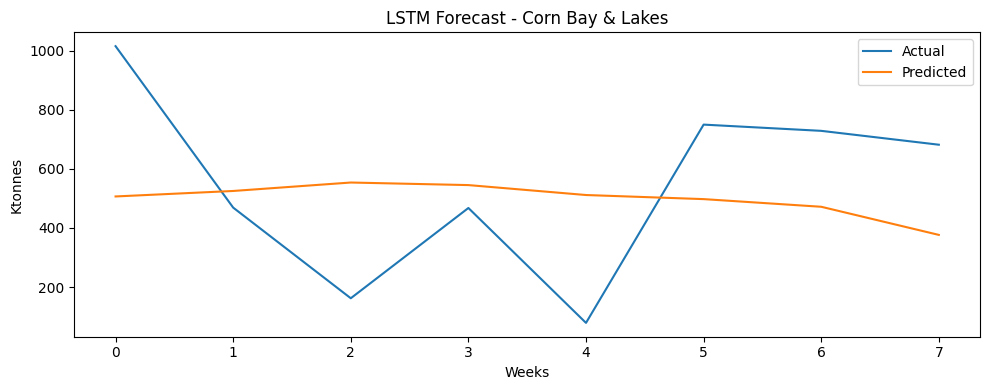

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f"✅ RMSE: {rmse:.2f} Ktonnes")

plt.figure(figsize=(10, 4))
plt.plot(y_test_inverse, label="Actual")
plt.plot(y_pred_inverse, label="Predicted")
plt.title("LSTM Forecast - Corn Bay & Lakes")
plt.xlabel("Weeks")
plt.ylabel("Ktonnes")
plt.legend()
plt.tight_layout()
plt.show()


📦 Processing: Corn_Bay&Lakes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


✅ Model saved: /content/lstm_outputs/lstm_Corn_BayandLakes.h5
📤 Predictions saved: /content/lstm_outputs/predictions_Corn_BayandLakes.csv


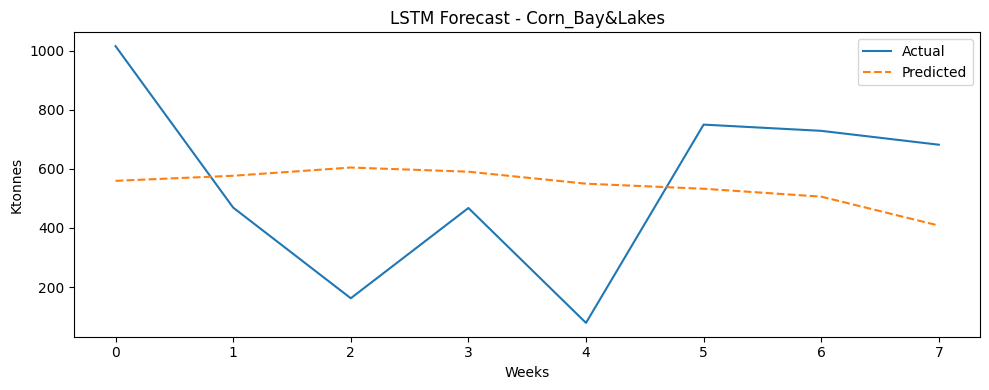


📦 Processing: Soybeans_Bay&Lakes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


✅ Model saved: /content/lstm_outputs/lstm_Soybeans_BayandLakes.h5
📤 Predictions saved: /content/lstm_outputs/predictions_Soybeans_BayandLakes.csv


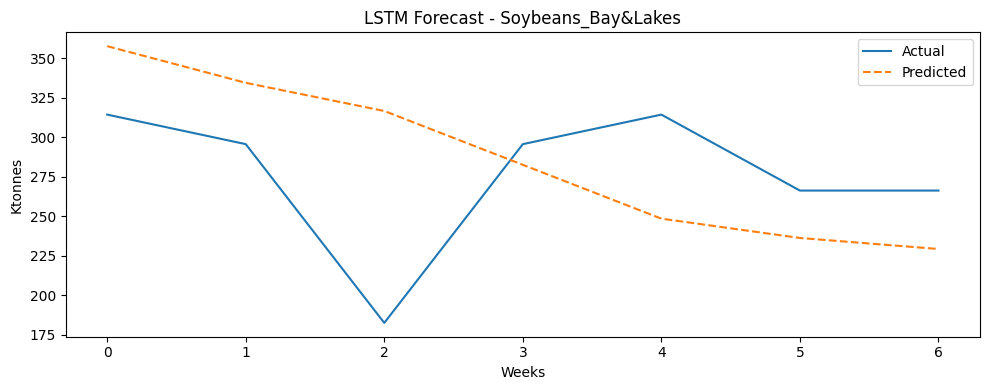


📦 Processing: Corn_St.Lawrence


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


✅ Model saved: /content/lstm_outputs/lstm_Corn_StLawrence.h5
📤 Predictions saved: /content/lstm_outputs/predictions_Corn_StLawrence.csv


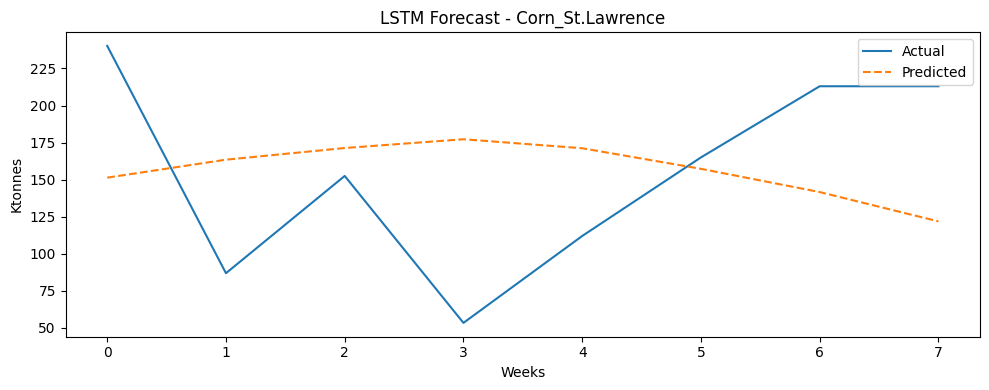


📦 Processing: Soybeans_St.Lawrence


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


✅ Model saved: /content/lstm_outputs/lstm_Soybeans_StLawrence.h5
📤 Predictions saved: /content/lstm_outputs/predictions_Soybeans_StLawrence.csv


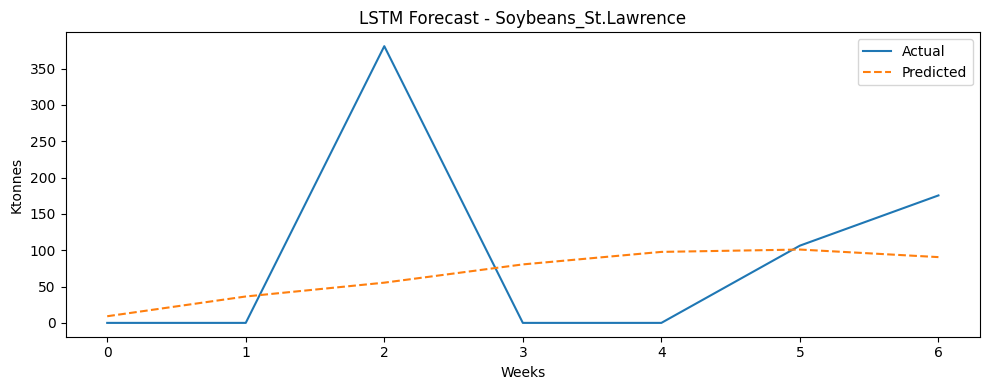

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# File and model output config
series_files = {
    "Corn_Bay&Lakes": "/content/corn_bay_lakes.csv",
    "Soybeans_Bay&Lakes": "/content/soybeans_bay_lakes.csv",
    "Corn_St.Lawrence": "/content/corn_st_lawrence.csv",
    "Soybeans_St.Lawrence": "/content/soybeans_st_lawrence.csv"
}

output_dir = "/content/lstm_outputs"
os.makedirs(output_dir, exist_ok=True)

# Sequence creator
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])
    return np.array(X), np.array(y)

# Loop through each dataset
for label, file in series_files.items():
    print(f"\n📦 Processing: {label}")

    df = pd.read_csv(file)

    # Grain week as number
    df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)
    df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
    df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)
    df = df.sort_values(["crop_year", "GW_num"]).reset_index(drop=True)

    # Normalize Ktonnes
    scaler = MinMaxScaler()
    df["Ktonnes_scaled"] = scaler.fit_transform(df[["Ktonnes"]])

    # Features
    features = df[["Ktonnes_scaled", "GW_sin", "GW_cos"]].values
    X, y = create_sequences(features, window=8)

    # Split
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    # Train
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    # Predict
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Save model
    model_path = f"{output_dir}/lstm_{label.replace('&','and').replace('.','').replace(' ','_')}.h5"
    model.save(model_path)
    print(f"✅ Model saved: {model_path}")

    # Save predictions
    pred_df = pd.DataFrame({
        "Actual_Ktonnes": y_test_rescaled.flatten(),
        "Predicted_Ktonnes": y_pred_rescaled.flatten()
    })
    pred_csv_path = f"{output_dir}/predictions_{label.replace('&','and').replace('.','').replace(' ','_')}.csv"
    pred_df.to_csv(pred_csv_path, index=False)
    print(f"📤 Predictions saved: {pred_csv_path}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(pred_df["Actual_Ktonnes"], label="Actual")
    plt.plot(pred_df["Predicted_Ktonnes"], label="Predicted", linestyle="--")
    plt.title(f"LSTM Forecast - {label}")
    plt.xlabel("Weeks")
    plt.ylabel("Ktonnes")
    plt.legend()
    plt.tight_layout()
    plt.show()


1. Add Validation Plots Across Crop Years

Goal:
Instead of training/validating randomly across the whole dataset, we validate by crop year, so you can see how the model performs year by year.

Strategy:
Split data by crop year, not just randomly

Train on 1–2 crop years and test on another

Plot actual vs predicted for each year separately


In [7]:
# Choose crop years to train on and test on
train_years = ["2022-2023", "2023-2024"]
test_years = ["2024-2025"]

# Filter training and testing sets
train_df = df[df["crop_year"].isin(train_years)]
test_df = df[df["crop_year"].isin(test_years)]

# Normalize based only on training set
scaler = MinMaxScaler()
train_df["Ktonnes_scaled"] = scaler.fit_transform(train_df[["Ktonnes"]])
test_df["Ktonnes_scaled"] = scaler.transform(test_df[["Ktonnes"]])

# Combine features
train_features = train_df[["Ktonnes_scaled", "GW_sin", "GW_cos"]].values
test_features = test_df[["Ktonnes_scaled", "GW_sin", "GW_cos"]].values

# Create sequences separately
X_train, y_train = create_sequences(train_features)
X_test, y_test = create_sequences(test_features)

<ipython-input-7-9a537b4fd134>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Ktonnes_scaled"] = scaler.fit_transform(train_df[["Ktonnes"]])
<ipython-input-7-9a537b4fd134>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Ktonnes_scaled"] = scaler.transform(test_df[["Ktonnes"]])


2. Forecast Multiple Weeks Ahead

🎯 Goal:
Forecast not just the next week (t+1), but t+4, t+8, etc.

Strategy:
Create multi-step labels: instead of 1 y value per sequence, predict a sequence of future steps

Your model output changes from shape (batch_size, 1) to (batch_size, steps_ahead)

In [8]:
def create_multi_sequences(data, window=8, steps_ahead=4):
    X, y = [], []
    for i in range(len(data) - window - steps_ahead + 1):
        X.append(data[i:i+window])
        y.append(data[i+window:i+window+steps_ahead, 0])  # predicting Ktonnes only
    return np.array(X), np.array(y)

In [9]:
steps_ahead = 4  # predict 4 weeks ahead
window = 8 # define window size
num_features = 3 # define number of features

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, num_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(steps_ahead)  # change output layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3. Use Production or Weather as Inputs (Multivariate LSTM)
🎯 Goal:
Feed the LSTM with external drivers like:

Crop production volume per crop year

Weekly average temperature / rainfall

Global trade price or demand index

Strategy:
Merge external data (e.g., production.csv) into your grain file using:

crop_year for annual features

week_ending_date for weekly features

Normalize and use them as additional features in LSTM

In [10]:
# Example: production per year
try:
    prod_df = pd.read_csv("/content/production_by_crop_year.csv")  # must include 'crop_year', 'production_volume'
    df = df.merge(prod_df, on="crop_year", how="left")
except FileNotFoundError:
    print("Error: 'production_by_crop_year.csv' not found. Please check the file path.")
    # Handle the error, e.g., skip this step or use default values

# If weather is by week:
try:
    weather = pd.read_csv("/content/weather_by_week.csv")  # must include 'week_ending_date', 'rain_mm', 'temp_avg'
    df = df.merge(weather, on="week_ending_date", how="left")
except FileNotFoundError:
    print("Error: 'weather_by_week.csv' not found. Please check the file path.")
    # Handle the error

Error: 'production_by_crop_year.csv' not found. Please check the file path.
Error: 'weather_by_week.csv' not found. Please check the file path.


In [11]:
# Example: production per year
try:
    prod_df = pd.read_csv("/content/production_by_crop_year.csv")  # must include 'crop_year', 'production_volume'
    df = df.merge(prod_df, on="crop_year", how="left")
except FileNotFoundError:
    print("Error: 'production_by_crop_year.csv' not found. Please check the file path.")
    # Handle the error, e.g., skip this step or use default values
    df['production_volume'] = 0  # Create a new column with default values

# If weather is by week:
try:
    weather = pd.read_csv("/content/weather_by_week.csv")  # must include 'week_ending_date', 'rain_mm', 'temp_avg'
    df = df.merge(weather, on="week_ending_date", how="left")
except FileNotFoundError:
    print("Error: 'weather_by_week.csv' not found. Please check the file path.")
    # Handle the error
    df['rain_mm'] = 0  # Create new columns with default values
    df['temp_avg'] = 0

Error: 'production_by_crop_year.csv' not found. Please check the file path.
Error: 'weather_by_week.csv' not found. Please check the file path.


LSTM with External Inputs + Plot (adding Use production or weather as new inputs (multivariate LSTM)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 0.2259 - val_loss: 0.1019
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1676 - val_loss: 0.0530
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1289 - val_loss: 0.0286
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1047 - val_loss: 0.0289
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0792 - val_loss: 0.0516
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1063 - val_loss: 0.0766
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0992 - val_loss: 0.0854
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1029 - val_loss: 0.0794


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


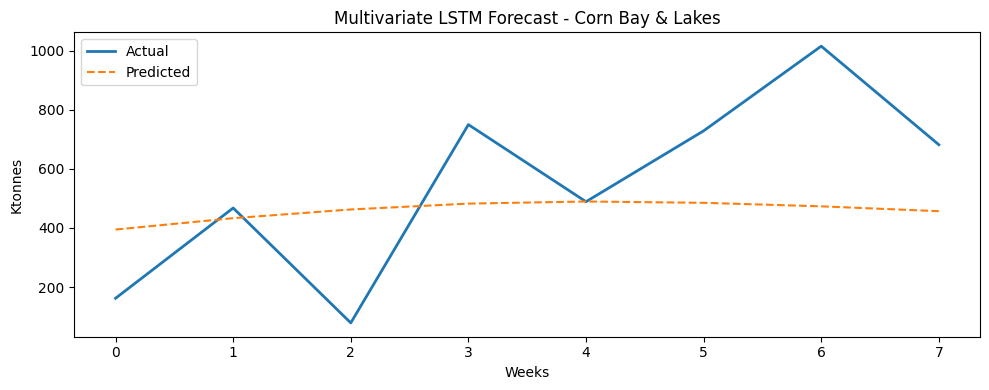

📉 RMSE with external features: 290.90 Ktonnes


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load merged dataset with production/weather
df = pd.read_csv("/content/corn_bay_lakes_with_weather_production.csv")

# Encode grain_week
df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)

# Fill NA in external features (use domain knowledge or simple fill)
df = df.fillna(0)

# Normalize all feature columns
feature_cols = ["Ktonnes", "GW_sin", "GW_cos", "production_volume", "rain_mm", "temp_avg"]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

# Sequence builder
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])  # predict Ktonnes
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window=8)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Train
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Predict
y_pred = model.predict(X_test)
y_test_rescaled = scaler.inverse_transform(np.hstack([y_test.reshape(-1, 1), np.zeros((len(y_test), len(feature_cols)-1))]))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.hstack([y_pred, np.zeros((len(y_pred), len(feature_cols)-1))]))[:, 0]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_rescaled, label="Actual", linewidth=2)
plt.plot(y_pred_rescaled, label="Predicted", linestyle="--")
plt.title("Multivariate LSTM Forecast - Corn Bay & Lakes")
plt.xlabel("Weeks")
plt.ylabel("Ktonnes")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"📉 RMSE with external features: {rmse:.2f} Ktonnes")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 808ms/step - loss: 0.1568 - val_loss: 0.0582
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1248 - val_loss: 0.0324
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0987 - val_loss: 0.0269
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.1115 - val_loss: 0.0427
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0954 - val_loss: 0.0673
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0963 - val_loss: 0.0751
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0891 - val_loss: 0.0706
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1002 - val_loss: 0.0588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


<ipython-input-16-4f493b5b9a0d>:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


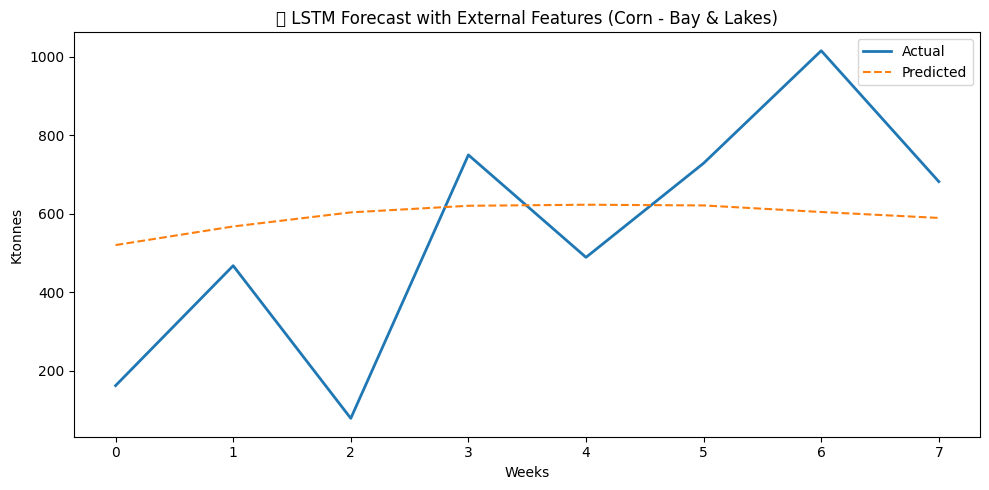

✅ RMSE: 282.03 Ktonnes


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset with external features
try:
    # Attempt to load the merged dataset
    df = pd.read_csv("/content/corn_bay_lakes_with_weather_production.csv")
except FileNotFoundError:
    # If the merged dataset is not found, load the original dataset
    print("Warning: 'corn_bay_lakes_with_weather_production.csv' not found. Using 'corn_bay_lakes.csv' instead.")
    df = pd.read_csv("/content/corn_bay_lakes.csv")
    # Create the missing columns and fill with 0
    df['production_volume'] = 0
    df['rain_mm'] = 0
    df['temp_avg'] = 0

# Grain week encoding
df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)

# ... (rest of your code remains the same)

# Fill NA values in external drivers
df.fillna(0, inplace=True)

# Select features (Ktonnes is target)
feature_cols = ["Ktonnes", "GW_sin", "GW_cos", "production_volume", "rain_mm", "temp_avg"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

# Sequence builder
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])  # Only Ktonnes is the target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, window=8)

# Split into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)

# Reverse normalization only for Ktonnes
def inverse_ktonnes(scaled_values):
    unscaled = scaler.inverse_transform(np.hstack([
        scaled_values.reshape(-1, 1), np.zeros((len(scaled_values), len(feature_cols)-1))
    ]))
    return unscaled[:, 0]

y_pred_rescaled = inverse_ktonnes(y_pred.flatten())
y_test_rescaled = inverse_ktonnes(y_test.flatten())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual", linewidth=2)
plt.plot(y_pred_rescaled, label="Predicted", linestyle="--")
plt.title("📈 LSTM Forecast with External Features (Corn - Bay & Lakes)")
plt.xlabel("Weeks")
plt.ylabel("Ktonnes")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"✅ RMSE: {rmse:.2f} Ktonnes")

Epoch 1/50


<ipython-input-17-3204a5d113fc>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step - loss: 0.1150 - val_loss: 0.0358
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0963 - val_loss: 0.0369
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0905 - val_loss: 0.0614
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0929 - val_loss: 0.0740
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0952 - val_loss: 0.0738
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0804 - val_loss: 0.0667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


<ipython-input-17-3204a5d113fc>:100: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


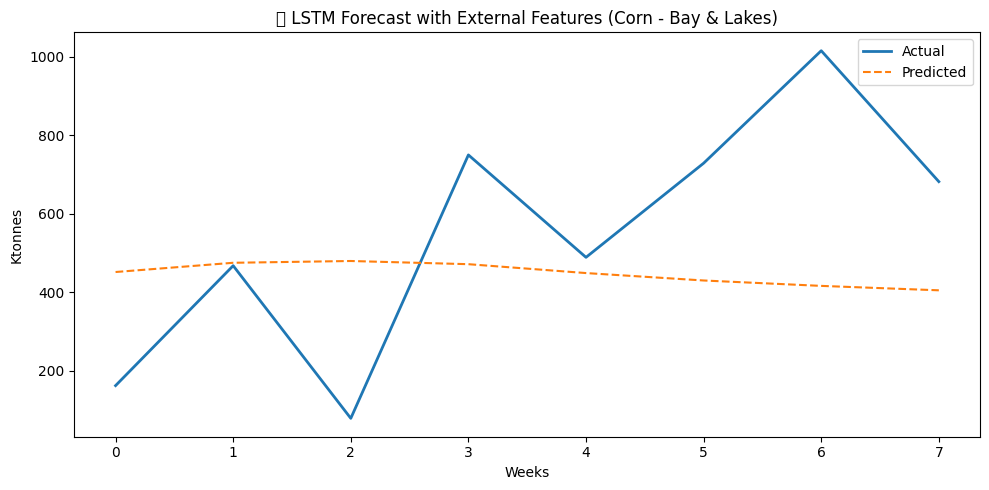

✅ RMSE: 325.43 Ktonnes


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset with external features
try:
    # Attempt to load the merged dataset
    df = pd.read_csv("/content/corn_bay_lakes_with_weather_production.csv")
except FileNotFoundError:
    # If the merged dataset is not found, load the original dataset
    print("Warning: 'corn_bay_lakes_with_weather_production.csv' not found. Using 'corn_bay_lakes.csv' instead.")
    df = pd.read_csv("/content/corn_bay_lakes.csv")
    # Create the missing columns and fill with 0
    df['production_volume'] = 0
    df['rain_mm'] = 0
    df['temp_avg'] = 0

# Grain week encoding
df["GW_num"] = df["grain_week"].str.extract("GW(\d+)").astype(int)
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)

# ... (rest of your code remains the same)

# Fill NA values in external drivers
# Check if the columns exist before filling NA values
# This ensures if the user doesn't provide those columns, they're automatically created with default values.
for col in ["production_volume", "rain_mm", "temp_avg"]:
    if col in df.columns:
        df[col].fillna(0, inplace=True)
    else:
        df[col] = 0

# Select features (Ktonnes is target)
feature_cols = ["Ktonnes", "GW_sin", "GW_cos", "production_volume", "rain_mm", "temp_avg"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

# Sequence builder
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])  # Only Ktonnes is the target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, window=8)

# Split into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Train model
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Make predictions
y_pred = model.predict(X_test)

# Reverse normalization only for Ktonnes
def inverse_ktonnes(scaled_values):
    unscaled = scaler.inverse_transform(np.hstack([
        scaled_values.reshape(-1, 1), np.zeros((len(scaled_values), len(feature_cols)-1))
    ]))
    return unscaled[:, 0]

y_pred_rescaled = inverse_ktonnes(y_pred.flatten())
y_test_rescaled = inverse_ktonnes(y_test.flatten())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label="Actual", linewidth=2)
plt.plot(y_pred_rescaled, label="Predicted", linestyle="--")
plt.title("📈 LSTM Forecast with External Features (Corn - Bay & Lakes)")
plt.xlabel("Weeks")
plt.ylabel("Ktonnes")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"✅ RMSE: {rmse:.2f} Ktonnes")

In [18]:
# Save the full DataFrame (with default or filled-in values) to CSV
df.to_csv("/content/corn_bay_lakes_with_weather_production.csv", index=False)
print("📁 File saved: corn_bay_lakes_with_weather_production.csv")

📁 File saved: corn_bay_lakes_with_weather_production.csv


In [19]:
# Save the trained model
model.save("/content/lstm_corn_bay_lakes.h5")
print("✅ Model saved as: lstm_corn_bay_lakes.h5")

✅ Model saved as: lstm_corn_bay_lakes.h5


In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse  # Import mse

# Load saved model
model = load_model("/content/lstm_corn_bay_lakes.h5", custom_objects={'mse': mse})

# Then you can run model.predict() or retrain it

In [21]:
import pandas as pd

import pandas as pd

# Load export data
# Updated file paths
df_22_23 = pd.read_csv('/content/gsw-shg-en 2022-2023.csv')
df_23_24 = pd.read_csv('/content/gsw-shg-en 2023-2024.csv')
df_24_25 = pd.read_csv('/content/gsw-shg-en 2024-2025.csv')

# Combine into one DataFrame
exports = pd.concat([df_22_23, df_23_24, df_24_25], ignore_index=True)

# 🔧 Example mock production data (replace with actual)
# Format: crop_year,commodity,production_volume
production = pd.DataFrame({
    'crop_year': [2022, 2023, 2024, 2022, 2023, 2024],  # Repeated years to match commodity length
    'commodity': ['Corn', 'Corn', 'Corn', 'Soybeans', 'Soybeans', 'Soybeans'],
    'production_volume': [1000, 1050, 1100, 800, 850, 900]
})

# 🔧 Example mock weather data (replace with actual)
# Format: grain_week,region,avg_temp,precipitation
weather = pd.DataFrame({
    'grain_week': exports['grain_week'].unique().tolist() * 2,
    'region': ['Bay & Lakes'] * len(exports['grain_week'].unique()) + ['St. Lawrence'] * len(exports['grain_week'].unique()),
    'avg_temp': [10] * len(exports['grain_week'].unique()) * 2,
    'precipitation': [5] * len(exports['grain_week'].unique()) * 2
})

# Rename the 'grain' column in exports to 'commodity' to match the production DataFrame
exports.rename(columns={'grain': 'commodity'}, inplace=True)

# Convert 'crop_year' in exports to int64 before merging
exports['crop_year'] = pd.to_numeric(exports['crop_year'], errors='coerce').astype('Int64')

# Merge production
exports = exports.merge(production, on=['crop_year', 'commodity'], how='left')

# Merge weather
exports = exports.merge(weather, on=['grain_week', 'region'], how='left')

# === Filter and export target files ===

# 1. Soybeans - Bay & Lakes
soybeans_bay_lakes = exports[
    (exports['commodity'] == 'Soybeans') & (exports['region'] == 'Bay & Lakes')
]
soybeans_bay_lakes.to_csv('soybeans_bay_lakes_with_weather_production.csv', index=False)

# 2. Corn - St. Lawrence
corn_st_lawrence = exports[
    (exports['commodity'] == 'Corn') & (exports['region'] == 'St. Lawrence')
]
corn_st_lawrence.to_csv('corn_st_lawrence_with_weather_production.csv', index=False)

# 3. Soybeans - St. Lawrence
soybeans_st_lawrence = exports[
    (exports['commodity'] == 'Soybeans') & (exports['region'] == 'St. Lawrence')
]
soybeans_st_lawrence.to_csv('soybeans_st_lawrence_with_weather_production.csv', index=False)

print("✅ Done! Files created.")

✅ Done! Files created.


In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define input/output paths
files = {
    "Corn_Bay&Lakes": "corn_bay_lakes_with_weather_production.csv",
    "Soybeans_Bay&Lakes": "soybeans_bay_lakes_with_weather_production.csv",
    "Corn_St.Lawrence": "corn_st_lawrence_with_weather_production.csv",
    "Soybeans_St.Lawrence": "soybeans_st_lawrence_with_weather_production.csv",
}

output_dir = "/content/lstm_models"
os.makedirs(output_dir, exist_ok=True)

# Sequence builder
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window][0])
    return np.array(X), np.array(y)

# Loop through all files
for label, file_name in files.items():
    print(f"\n📦 Processing: {label}")
    file_path = f"/content/{file_name}"

    df = pd.read_csv(file_path)

df = pd.read_csv(file_path)

# Add grain week as numeric + seasonal signals
df["GW_num"] = pd.to_numeric(df["grain_week"].astype(str).str.extract("(\d+)")[0], errors='coerce').fillna(0).astype(int)
df["GW_sin"] = np.sin(2 * np.pi * df["GW_num"] / 52)
df["GW_cos"] = np.cos(2 * np.pi * df["GW_num"] / 52)

# Ensure external feature columns exist, if not, create and fill with 0
for col in ["production_volume", "rain_mm", "temp_avg"]:
    if col not in df.columns:
        df[col] = 0

# Convert 'Ktonnes' to numeric, handling commas
df['Ktonnes'] = pd.to_numeric(df['Ktonnes'].str.replace(',', ''), errors='coerce')

df.fillna(0, inplace=True) # Fill any remaining NaN values with 0

# Features
# ... (rest of your code)


📦 Processing: Corn_Bay&Lakes

📦 Processing: Soybeans_Bay&Lakes

📦 Processing: Corn_St.Lawrence

📦 Processing: Soybeans_St.Lawrence


In [23]:
    # Features
    feature_cols = ["Ktonnes", "GW_sin", "GW_cos", "production_volume", "rain_mm", "temp_avg"]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols])

    # Build sequences
    X, y = create_sequences(scaled, window=8)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Build model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")

    # Train model
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    # Predict
    y_pred = model.predict(X_test)

    # Inverse scaling for Ktonnes
    def inverse_ktonnes(scaled_vals):
        dummy = np.zeros((len(scaled_vals), len(feature_cols)))
        dummy[:, 0] = scaled_vals
        return scaler.inverse_transform(dummy)[:, 0]

    y_pred_rescaled = inverse_ktonnes(y_pred.flatten())
    y_test_rescaled = inverse_ktonnes(y_test.flatten())

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_rescaled, label="Actual", linewidth=2)
    plt.plot(y_pred_rescaled, label="Predicted", linestyle="--")
    plt.title(f"LSTM Forecast: {label}")
    plt.xlabel("Weeks")
    plt.ylabel("Ktonnes")
    plt.legend()
    plt.tight_layout()
    plot_path = f"{output_dir}/{label.replace(' ', '_').replace('&','and')}_plot.png"
    plt.savefig(plot_path)
    plt.close()

    # Save model
    model_path = f"{output_dir}/{label.replace(' ', '_').replace('&','and')}.h5"
    model.save(model_path)

    # Save predictions
    pred_df = pd.DataFrame({
        "Actual_Ktonnes": y_test_rescaled,
        "Predicted_Ktonnes": y_pred_rescaled
    })
    pred_df.to_csv(f"{output_dir}/{label.replace(' ', '_').replace('&','and')}_predictions.csv", index=False)

    print(f"✅ Model, plot, and predictions saved for {label}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


✅ Model, plot, and predictions saved for Soybeans_St.Lawrence
